In [3]:
from db import execute_query
import numpy as np
from collections import defaultdict

In [98]:
"""Create the calibration/test splits"""

from sklearn.model_selection import train_test_split

query = f"""
select audio_id, background_modifier_id, audio_info_id
from audio_data 
"""

class Audio:
    def __init__(self, row):
        self.audio_id = row[0]
        self.background_modifier = row[1]
        self.info_id = row[2]

data = execute_query(query)

audio_ids = np.array([Audio(d) for d in data])
background_modifier_ids = np.array([d[1] for d in data])
audio_info_ids = np.array([d[2] for d in data])

labels = np.array(list(zip(background_modifier_ids, audio_info_ids)))
audio_train, audio_test, _, _ = train_test_split(audio_ids, labels, test_size=0.2, stratify=labels, random_state=42)

calibration_ids = [audio.audio_id for audio in audio_train]
calibration_features = [audio.background_modifier for audio in audio_train]

validation_ids = [audio.audio_id for audio in audio_test]
validation_features = [audio.background_modifier for audio in audio_test]

In [ ]:
def count(lst):
    m = defaultdict(int)
    for i in lst:
        m[i.background_modifier] += 1
        
    return m

def count1(lst):
    m = defaultdict(int)
    for i in lst:
        m[i.info_id] += 1
        
    return m

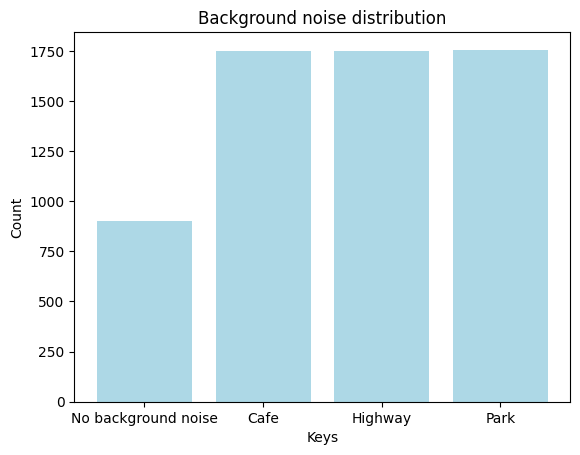

In [88]:
import matplotlib.pyplot as plt

data = count(audio_train)

keys = ["No background noise", "Cafe", "Highway", "Park"]
values = [data[k] for k in sorted(data.keys())]

plt.bar(keys, values, color='lightblue')

plt.xlabel('Keys')
plt.ylabel('Count')
plt.title('Background noise distribution')

plt.show()

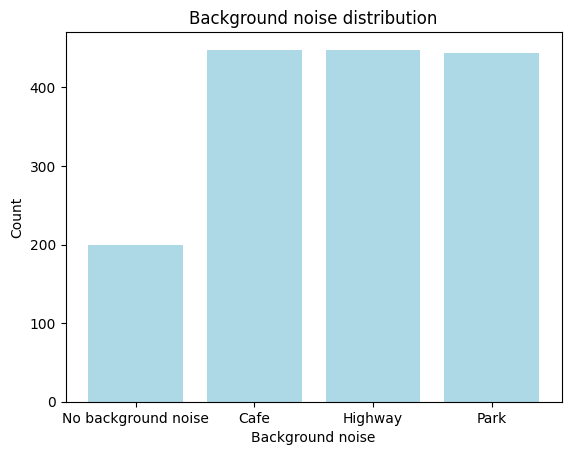

In [89]:
import matplotlib.pyplot as plt

data = count(audio_test)

keys = ["No background noise", "Cafe", "Highway", "Park"]
values = [data[k] for k in sorted(data.keys())]

plt.bar(keys, values, color='lightblue')

plt.xlabel('Background noise')
plt.ylabel('Count')
plt.title('Background noise distribution')

plt.show()

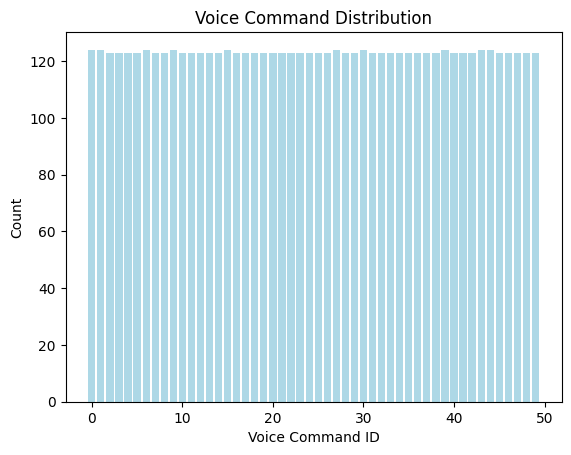

In [85]:
import matplotlib.pyplot as plt

data = count1(audio_train)

keys = list(data.keys())
values = list(data.values())

plt.bar(keys, values, color='lightblue')

plt.xlabel('Voice Command ID')
plt.ylabel('Count')
plt.title('Voice Command Distribution')

plt.show()

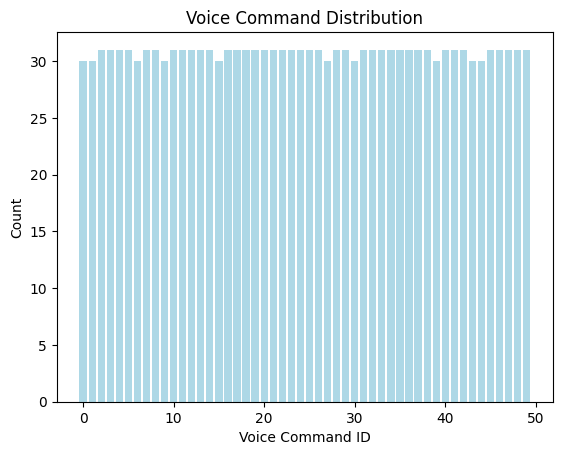

In [87]:
import matplotlib.pyplot as plt

data = count1(audio_test)

keys = list(data.keys())
values = list(data.values())

plt.bar(keys, values, color='lightblue')

plt.xlabel('Voice Command ID')
plt.ylabel('Count')
plt.title('Voice Command Distribution')

plt.show()

In [99]:
"""Construct the datasets for Conformal Risk Control"""

def create_mapping(data):
    mapping = {}
    idx = 0
    for item in data:
        audio_id = item[0]
        if audio_id not in mapping:
            mapping[audio_id] = idx
            idx += 1
    return mapping

n = len(calibration_ids)
calibration_predictions = [[] for _ in range(n)]
calibration_confidence_scores = [[] for _ in range(n)]
calibration_word_error_rates = [[] for _ in range(n)]
calibration_audio_info_ids = [[] for _ in range(n)]
c_background_modifier_ids = [[] for _ in range(n)]

query = f"""
select Audio_ID, Prediction, Confidence_Score, Word_Error_Rate, Audio_Info_ID, Background_Modifier_ID
from audio_data 
natural join audio_predictions
where audio_id in {tuple(calibration_ids)}
"""
rows = execute_query(query)
mapping = create_mapping(rows)

for row in rows:
    idx = mapping[row[0]]
    calibration_predictions[idx].append(row[1])
    calibration_confidence_scores[idx].append(row[2])
    calibration_word_error_rates[idx].append(row[3])
    calibration_audio_info_ids[idx].append(row[4])
    c_background_modifier_ids[idx].append(row[5])
        
n = len(validation_ids)
validation_predictions = [[] for _ in range(n)]
validation_confidence_scores = [[] for _ in range(n)]
validation_word_error_rates = [[] for _ in range(n)]
validation_audio_info_ids = [[] for _ in range(n)]
v_background_modifier_ids = [[] for _ in range(n)]

query = f"""
select Audio_ID, Prediction, Confidence_Score, Word_Error_Rate, Audio_Info_ID, Background_Modifier_ID
from audio_data 
natural join audio_predictions
where audio_id in {tuple(validation_ids)}
"""
rows = execute_query(query)
mapping = create_mapping(rows)

for row in rows:
    idx = mapping[row[0]]
    validation_predictions[idx].append(row[1])
    validation_confidence_scores[idx].append(row[2])
    validation_word_error_rates[idx].append(row[3])
    validation_audio_info_ids[idx].append(row[4])
    v_background_modifier_ids[idx].append(row[5])
    
def flat(input_list):
    flattened_list = []
    for sublist in input_list:
        if isinstance(sublist, list):
            if sublist:  # Check if the sublist is not empty
                flattened_list.append(sublist[0])
        else:
            flattened_list.append(sublist)
    return flattened_list
    
calibration_features = flat(c_background_modifier_ids)
validation_features = flat(v_background_modifier_ids)

In [100]:
"""Code to compute the weight for each calibration data point"""

from sklearn.ensemble import RandomForestClassifier

def compute_weight_schedule(calibration_features, validation_features):
    X, y = calibration_features + validation_features, [0] * len(calibration_features) + [1] * len(validation_features)
    X, y = np.array(X).reshape(-1, 1), np.array(y)

    binary_classifier = RandomForestClassifier()
    binary_classifier.fit(X, y)
    
    weight_fn = {}
    feature_set = set(calibration_features) | set(validation_features)
    for feature in feature_set:
        probabilities = binary_classifier.predict_proba([[feature]])[0]
        print(feature, probabilities)
        weight_fn[feature] = probabilities[1] / (1 - probabilities[1])

    weight_schedule = [weight_fn[feature] for feature in calibration_features]
    return weight_schedule, weight_fn, binary_classifier

In [ ]:
"""Uncomment block to use weighted CRC for calibration"""

# weights, weight_fn, classifier = compute_weight_schedule(calibration_features, validation_features)

In [101]:
"""Uncomment this block to use unweighted CRC for calibration"""

weights = np.array([1] * len(calibration_features))

feature_set = set(calibration_features) | set(validation_features)
weight_fn = {}
for feature in feature_set:
    weight_fn[feature] = 1

classifier = None

In [102]:
"""Conformal prediction parameters"""

B = 1
alpha = 0.4
threshold = 0.4  # target word error rate

In [103]:
"""Code for Conformal Risk Control"""

import functools
import numpy as np
from scipy.optimize import brentq

def cumsum_2d_list(lst):
    result = []
    for row in lst:
        cum_sum_row = []
        cum_sum = 0
        for num in row:
            cum_sum += num
            cum_sum_row.append(cum_sum)
        result.append(cum_sum_row)
    return result

def find_first_ge_index(cumsum_list, lam):
    for row_idx, value in enumerate(cumsum_list):
        if value >= lam:
            return row_idx
    return len(cumsum_list) - 1

def all_greater_or_equal(w, wer_target):
    for element in w:
        if element < wer_target:
            return 0
    return 1

def c_lam(lam, smx):
    """Compute prediction set indexes using lambda"""
#     prefix_sums = np.cumsum(smx, axis=1)
    prefix_sums = cumsum_2d_list(smx)
    threshold_indexes = [None for _ in range(len(prefix_sums))]
    for idx, row in enumerate(prefix_sums):
        threshold_idx = find_first_ge_index(row, lam)
        threshold_indexes[idx] = threshold_idx if row[threshold_idx] >= lam else len(row) - 1
    return threshold_indexes

def loss(wers, wer_target):
    """Compute array of losses"""
    return np.array([all_greater_or_equal(w, wer_target) for w in wers])

def losses(lam, smx, wers, wer_target, debug=False):
    """Compute array of losses given Lambda, also compute weight schedule"""
    idxs = c_lam(lam, smx)
    prediction_wers = []
    for idx, threshold_idx in enumerate(idxs):
        prediction_wers.append(wers[idx][:threshold_idx+1])
        
    if debug:
        total_length = 0
        for prediction_wer in prediction_wers:
            total_length += len(prediction_wer)
        print("Mean set size", total_length / len(prediction_wers))

    return loss(prediction_wers, wer_target)

def conformal_risk_control(lam, smx, wers, wer_target, weight_schedule, test_feature_weight=None):
    """This is where conformal risk control happens"""
    n = len(smx)
    loss_values = losses(lam, smx, wers, wer_target)
    
    weighted_sum = 0
    for idx, loss in enumerate(loss_values):
        weighted_sum += weight_schedule[idx] * loss
        
    if test_feature_weight is None:
        return weighted_sum / sum(weight_schedule) - ((n+1)/n*alpha - 1/(n+1))
    
    return (weighted_sum + test_feature_weight * B) / (sum(weight_schedule) + test_feature_weight) - ((n+1)/n*alpha - 1/(n+1))

def compute_lamhat(
        confidence_scores, 
        word_error_rates, 
        wer_target, 
        weight_schedule,
        test_feature_weight=None):
    """Search for value of lambda that controls the WER"""
    crc_partial = functools.partial(
        conformal_risk_control, smx=confidence_scores, wers=word_error_rates, 
        wer_target=wer_target, weight_schedule=weight_schedule,
        test_feature_weight=test_feature_weight)
    try:
        return brentq(crc_partial, 0, 1)
    except ValueError as e:
        if crc_partial(0) > 0:
            return 1
        else:
            return 0

Calibration data: Min coverage = 0.5342532467532468, max coverage = 0.6863636363636363)
Validation Data: min coverage = 0.5409090909090909, max coverage = 0.6824675324675324)


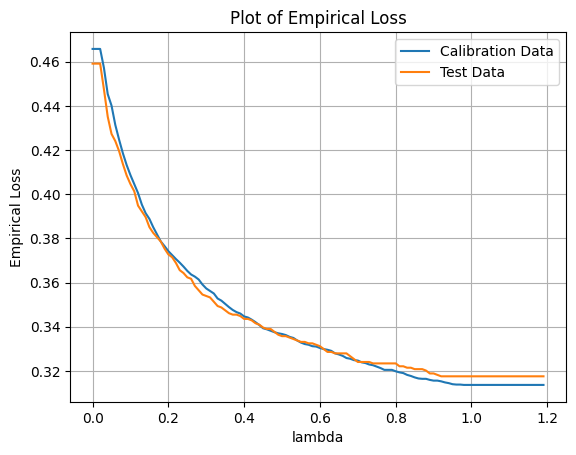

In [104]:
"""Visualise Empirical loss curves"""

import matplotlib.pyplot as plt

def crc_util(lam, smx, wers, wer_target, weight_schedule):
    """Utility function to visualise empirical loss"""
    loss_values = losses(lam, smx, wers, wer_target)
    
    weighted_sum = 0
    for idx, loss in enumerate(loss_values):
        weighted_sum += weight_schedule[idx] * loss

    return weighted_sum / sum(weight_schedule)


x_values = np.arange(0, 1.2, 0.01)

# Define the first set of data
smx_calib = calibration_confidence_scores
wers_calib = calibration_word_error_rates

crc_partial_calib_1 = functools.partial(
    crc_util, 
    smx=smx_calib, 
    wers=wers_calib, 
    wer_target=threshold, 
    weight_schedule=[1] * len(calibration_ids))

print(f"Calibration data: Min coverage = {1-crc_partial_calib_1(0)}, max coverage = {1-crc_partial_calib_1(1)})")

y_values_1 = [crc_partial_calib_1(x) for x in x_values]
plt.plot(x_values, y_values_1, label='Calibration Data')

smx_test= validation_confidence_scores
wers_test = validation_word_error_rates

crc_partial_test = functools.partial(
    crc_util, 
    smx=smx_test, 
    wers=wers_test, 
    wer_target=threshold, 
    weight_schedule=[1] * len(validation_ids))

print(f"Validation Data: min coverage = {1-crc_partial_test(0)}, max coverage = {1-crc_partial_test(1)})")

y_values_test = [crc_partial_test(x) for x in x_values]
plt.plot(x_values, y_values_test, label='Test Data')


plt.xlabel('lambda')
plt.ylabel('Empirical Loss')
plt.title('Plot of Empirical Loss')
plt.grid(True)
plt.legend()
plt.show()

In [105]:
"""Compute 3D plot of Empirical loss space"""

import matplotlib.pyplot as plt

def crc_util(lam, smx, wers, wer_target, weight_schedule):
    loss_values = losses(lam, smx, wers, wer_target)
    
    weighted_sum = 0
    for idx, loss in enumerate(loss_values):
        weighted_sum += weight_schedule[idx] * loss

    return weighted_sum / sum(weight_schedule)

x_range = (0, 1)
y_range = (0, 1)
step = 0.05

x_values = np.arange(x_range[0], x_range[1] + step, step)
y_values = np.arange(y_range[0], y_range[1] + step, step)

x_values, y_values = np.meshgrid(x_values, y_values)

z_values = np.zeros_like(x_values)

smx_1 = calibration_confidence_scores
wers_1 = calibration_word_error_rates

for i in range(len(x_values)):
    for j in range(len(y_values)):
        crc_partial_1 = functools.partial(
            crc_util, smx=smx_1, wers=wers_1, 
            wer_target=y_values[i, j], weight_schedule=[1] * len(calibration_ids))
        
        z_values[i, j] = crc_partial_1(x_values[i, j])


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x_values, y_values, z_values, cmap='viridis')

ax.set_xlabel('Lambda')
ax.set_ylabel('Target Word Error Rate')
ax.set_zlabel('Empirical Loss')
ax.set_title('Lambda and Error Rate Dependency in Empirical Loss Space')

ax.view_init(elev=20, azim=30)

plt.show()

KeyboardInterrupt: 

In [106]:
"""Compute lambda hat"""

lamhat = compute_lamhat(calibration_confidence_scores, calibration_word_error_rates, threshold, weights)
lamhat

0.1210598726477791

In [107]:
"""Compute the coverage and mean set size for calibration set"""

ls = losses(lamhat, calibration_confidence_scores, calibration_word_error_rates, threshold, debug=True)
print("Coverage:", 1 - ls.mean())

Mean set size 3.625
Coverage: 0.6001623376623377


In [108]:
"""Compute the coverage and mean set size for validation set"""

ls = losses(lamhat, validation_confidence_scores, validation_word_error_rates, threshold, debug=True)
print("Coverage: ", 1 - ls.mean())

Mean set size 3.601948051948052
Coverage:  0.6051948051948052


In [48]:
"""Compute the coverage and mean set size using transductive approach"""

n = len(validation_confidence_scores)
lamhats = np.empty(n)
ls = np.empty(n)
set_sizes = np.empty(n)

for idx in range(n):
    feature = validation_features[idx]
    weight = weight_fn[feature]
    
    vcs = np.array([validation_confidence_scores[idx]])
    vwer = np.array([validation_word_error_rates[idx]])
    
    lamhat = compute_lamhat(
        np.array(calibration_confidence_scores), 
        np.array(calibration_word_error_rates), 
        threshold, 
        weights,
        test_feature_weight=weight
    )
    
    lamhats[idx] = lamhat
    ls[idx] = losses(lamhat, vcs, vwer, threshold)
    set_sizes[idx] = c_lam(lamhat, vcs)[0] + 1
    
print("Coverage: ", 1 - ls.mean())
print("Mean set size: ", set_sizes.mean())

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6282,) + inhomogeneous part.

In [145]:
"""Compute an example prediction set"""

n = 586

idxs = c_lam(lamhat, [validation_confidence_scores[n]])
sentences = [w.strip() for w in validation_predictions[n][:idxs[0]+1]]
scores = validation_confidence_scores[n][:idxs[0]+1]
sentences = list(zip(sentences, scores))

print("Ground truth sentence: Take me to office 13.\n")
print("-- Predicted sentences (confidence score) --")
for s in sentences:
    print(s[0], f"({s[1]})")
    
validation_predictions[n]

Ground truth sentence: Take me to office 13.

-- Predicted sentences (confidence score) --
take me to office fourteen (0.06319142645507726)
take me to office thirteen (0.05843916652564615)


['take me to office fourteen',
 'take me to office thirteen',
 'take me to office forty',
 'take me to office thirty',
 'take me to office twelve',
 'take me to office',
 'take me to office fifteen',
 'take me to office for two',
 'take me to office shortly',
 'take me to office for tea',
 'thank me to office fourteen',
 'take me to office twenty',
 'take me to office working',
 'take me to office at thirteen',
 'take me to office for dinner',
 'take me to office for you',
 'take me to officer thirteen',
 'thank me to office thirteen',
 'take me to office for me',
 'take me to office for a few minutes',
 'take me to office for two minutes',
 'take me to office parking',
 'take me to office for two weeks']

In [146]:
"""Compute an example prediction set"""

n = 1

idxs = c_lam(lamhat, [validation_confidence_scores[n]])
sentences = [w.strip() for w in validation_predictions[n][:idxs[0]+1]]
scores = validation_confidence_scores[n][:idxs[0]+1]
sentences = list(zip(sentences, scores))

print("Ground truth sentence: Take me to office 13.\n")
print("-- Predicted sentences (confidence score) --")
for s in sentences:
    print(s[0], f"({s[1]})")
    
validation_predictions[n]

Ground truth sentence: Take me to office 13.

-- Predicted sentences (confidence score) --
take me to office thirteen (0.08353685840533634)
take me to office thirty (0.07185259998979025)


['take me to office thirteen',
 'take me to office thirty',
 'take me to fis thirteen',
 'take me to office therapy',
 'take me to office thirty minutes',
 'take me to ephes thirteen',
 'take me to office13',
 'take me to office 3rd team',
 'take me to the office thirteen',
 'dont take me to office thirteen',
 'they need to office thirteen',
 'take me to fisk thirteen',
 'take me to office thirty years',
 'take me to office thursday',
 'take me to office thrab team',
 'take me to aufus thirteen',
 'take me to officer thirteen',
 'dig me to office thirteen',
 'take me to office thrifting']

In [147]:
"""Compute an example prediction set"""

n = 679

idxs = c_lam(lamhat, [validation_confidence_scores[n]])
sentences = [w.strip() for w in validation_predictions[n][:idxs[0]+1]]
scores = validation_confidence_scores[n][:idxs[0]+1]
sentences = list(zip(sentences, scores))

print("Ground truth sentence: Take me to office 13.\n")
print("-- Predicted sentences (confidence score) --")
for s in sentences:
    print(s[0], f"({s[1]})")
    
validation_predictions[n]

Ground truth sentence: Take me to office 13.

-- Predicted sentences (confidence score) --
take me to office for dinner (0.04667803200756297)
take me to office of dinner (0.046295887012030766)
take me to office thirteen (0.0425626816452112)


['take me to office for dinner',
 'take me to office of dinner',
 'take me to office thirteen',
 'take me to official dinner',
 'take me to the office of dinner',
 'take me to office thank you',
 'take me to office or dinner',
 'take me to our physical team',
 'take me to all this sort of thing',
 'take me to office of dino',
 'take me to office routine',
 'take me to office for a dinner',
 'take me to office',
 'take me to office until the end',
 'take me to office saturday',
 'take me to office at the end',
 'take me to office so thank you',
 'take me to a physical team',
 'take me to the office of dino',
 'take me to the office for dinner',
 'take me to office for the evening',
 'take me to a physical deal',
 'take me to official theme',
 'take me to officer dinner',
 'take me to office for the end',
 'take me to officer dino',
 'take me to of his thirteen',
 'take me to of his 13th',
 'take me to office shortly']

In [151]:
"""Compute an example prediction set"""

n = 1512

idxs = c_lam(lamhat, [validation_confidence_scores[n]])
sentences = [w.strip() for w in validation_predictions[n][:idxs[0]+1]]
scores = validation_confidence_scores[n][:idxs[0]+1]
sentences = list(zip(sentences, scores))

print("Ground truth sentence: Take me to office 13.\n")
print("-- Predicted sentences (confidence score) --")
for s in sentences:
    print(s[0], f"({s[1]})")
    
validation_predictions[n]

Ground truth sentence: Take me to office 13.

-- Predicted sentences (confidence score) --
take me to office thirteen (0.2982108888809585)


['take me to office thirteen',
 'take me to office13',
 'take me to office xiii',
 'thank me to office thirteen',
 'take me to officer thirteen']

In [130]:
res = []
for idx, pred in enumerate(validation_predictions):
    if any(['office' in x for x in pred]):
        res.append(idx)

In [131]:
res

[1,
 5,
 93,
 112,
 188,
 197,
 252,
 310,
 323,
 372,
 470,
 474,
 586,
 618,
 679,
 717,
 782,
 795,
 920,
 1033,
 1066,
 1095,
 1111,
 1116,
 1123,
 1152,
 1243,
 1279,
 1298,
 1367,
 1453,
 1469,
 1512]

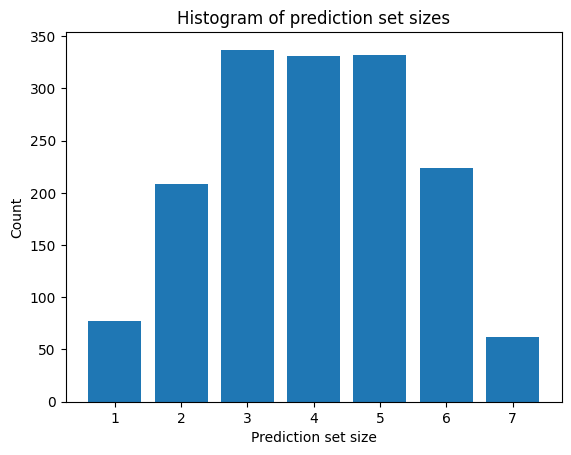

In [49]:
"""Compute a histogram of prediction set sizes"""

import matplotlib.pyplot as plt
from collections import Counter

idxs = c_lam(lamhat, validation_confidence_scores)
lengths = [i + 1 for i in idxs]

length_counts = Counter(lengths)
lengths = list(length_counts.keys())
counts = list(length_counts.values())

plt.bar(lengths, counts)

plt.xlabel('Prediction set size')
plt.ylabel('Count')
plt.title('Histogram of prediction set sizes')

plt.show()

In [ ]:
"""Compute the Feature Stratified Coverage"""

def flat(input_list):
    flattened_list = []
    for sublist in input_list:
        if isinstance(sublist, list):
            if sublist:
                flattened_list.append(sublist[0])
        else:
            flattened_list.append(sublist)
    return flattened_list

def group(ls, bgs):
    grouped_data = {}
    for bg, item in zip(bgs, ls):
        if bg in grouped_data:
            grouped_data[bg].append(item)
        else:
            grouped_data[bg] = [item]
    return grouped_data

validation_background_modifier_ids = flat(v_background_modifier_ids)
grouped_data = group(1 - ls, validation_background_modifier_ids)

feature_stratified_coverage = {}

for key, value in grouped_data.items():
    feature_stratified_coverage[key] = sum(value) / len(value)

feature_stratified_coverage